# Advanced Qiskit - Compilation overview（コンパイルの概要）

## 背景
Qiskitは、量子コンピュータを扱うためのPython SDKであり、異なる量子コンピュータを対象とした回路に変換するためのコンパイラーフレームワークと、異なる量子コンピュータアーキテクチャ上でプログラムや計算プリミティブを実行するための共通インターフェースを提供します。

このチュートリアルでは、Qiskitに組み込まれているデフォルトのコンパイルがどのように機能するかを説明します。


<!-- ## Background
Qiskit is a Python SDK for working with Quantum computers which includes a compiler framework for transforming those circuits that can target different quantum computers and a common interface for running programs and computational primitives on different quantum computer architectures.

This tutorial covers how the built-in/default compilation in Qiskit works. -->

## 必要条件

このチュートリアルを始める前に、以下がインストールされていることを確認してください：
- Qiskit SDK v1.0以降（ビジュアライゼーションサポート付き）: `pip install 'qiskit[visualization]'`
- Qiskit Runtime 0.28以降: `pip install qiskit-ibm-runtime`
- Rustworkxグラフライブラリ: `pip install rustworkx`


<!-- ## Requirements

Before starting this tutorial, be sure you have the following installed:
- Qiskit SDK v1.0 or later, with visualization support ( `pip install 'qiskit[visualization]'` )
- Qiskit Runtime 0.28 or later (`pip install qiskit-ibm-runtime`)
- Rustworkx graph library (`pip install rustworkx`) -->

In [ ]:
!pip install qiskit
!pip install "qiskit[visualization]"
!pip install qiskit-ibm-runtime
!pip install rustworkx

## 量子回路
Qiskitは量子計算の回路モデルに基づいています。そのため、Qiskitが理解できるようにするためには、すべての量子アルゴリズムを量子回路のコレクションとして表現する必要があります。


<!-- ## Quantum Circuits
Qiskit is based on the circuit model of quantum computation. Therefore any quantum algorithm needs to be represented by a collection of quantum circuits to be understood by Qiskit. -->

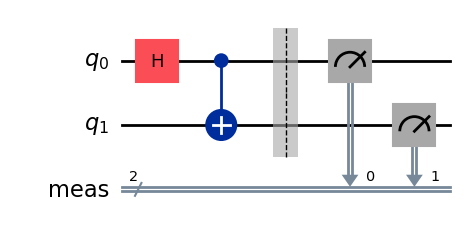

In [ ]:
from qiskit.circuit import QuantumCircuit

qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.measure_all()

qc.draw('mpl')


内部的に、この回路は`CircuitInstruction`オブジェクトのリストであり、基本的には以下の形式の操作とオペランドを表します：
```python
CircuitInstruction(op, qubits, clbits)
```
ゲートが追加されるたびに、そのリストに追加されます：


<!-- Internally this circuit is a list of `CircuitInstruction` object which is basically just the operation and operands of the form:
```python
CircuitInstruction(op, qubits, clbits)
```
Everytime a gate is added it's appended to that list: -->

In [ ]:
import pprint
pprint.pprint(list(qc.data))

[CircuitInstruction(operation=Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(2, 'q'), 0),), clbits=()),
 CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(2, 'q'), 0), Qubit(QuantumRegister(2, 'q'), 1)), clbits=()),
 CircuitInstruction(operation=Instruction(name='barrier', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(2, 'q'), 0), Qubit(QuantumRegister(2, 'q'), 1)), clbits=()),
 CircuitInstruction(operation=Instruction(name='measure', num_qubits=1, num_clbits=1, params=[]), qubits=(Qubit(QuantumRegister(2, 'q'), 0),), clbits=(Clbit(ClassicalRegister(2, 'meas'), 0),)),
 CircuitInstruction(operation=Instruction(name='measure', num_qubits=1, num_clbits=1, params=[]), qubits=(Qubit(QuantumRegister(2, 'q'), 1),), clbits=(Clbit(ClassicalRegister(2, 'meas'), 1),))]


### ネストされたオブジェクト

また、抽象的な要素を組み合わせて回路を構築することで、より高いレベルの抽象化を構築することもできます。


<!-- ### Nested Objects

You can also build higher levels of abstraction and build circuits by composing those abstract elements -->

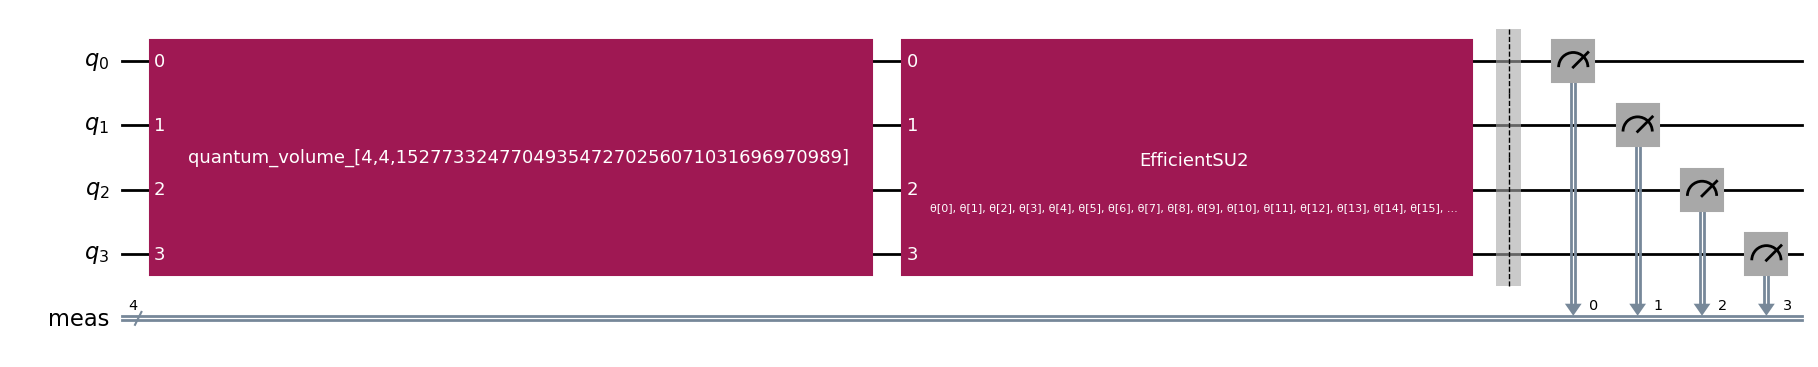

In [ ]:
from qiskit.circuit.library import QuantumVolume, EfficientSU2


nested_qc = QuantumCircuit(4, name="Nested example")
nested_qc.append(QuantumVolume(4), range(4))
nested_qc.append(EfficientSU2(4, entanglement="circular", reps=5), range(4))
nested_qc.measure_all()
nested_qc.draw('mpl', fold=-1)

2量子ビットゲートの深さに関する正しい情報（互いに離れた量子ビットセットに作用する2量子ビットゲートの層）を得るためには、回路を基本的なコンポーネント（例えば、CXゲート）まで分解することが重要です。これは、下記のようにネストされたオブジェクトを持つ回路に対して`decompose`メソッドを何度も繰り返し実行する必要がある場合があります。


<!-- To get the correct information about the depth of two-qubit gates (layers of 2q gates acting on disjoint set of qubits) it is important to decompose the circuit all the way to the basic components (e.g. CX gate). This may require several repetition of the `decompose` method for circuits with nested objects as shown below. -->

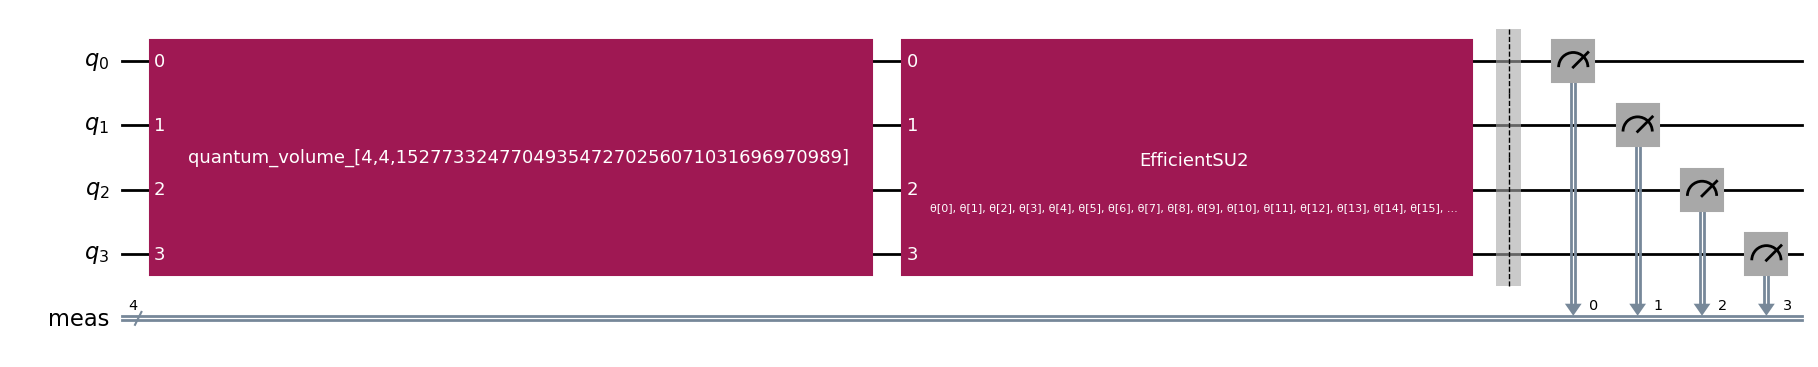

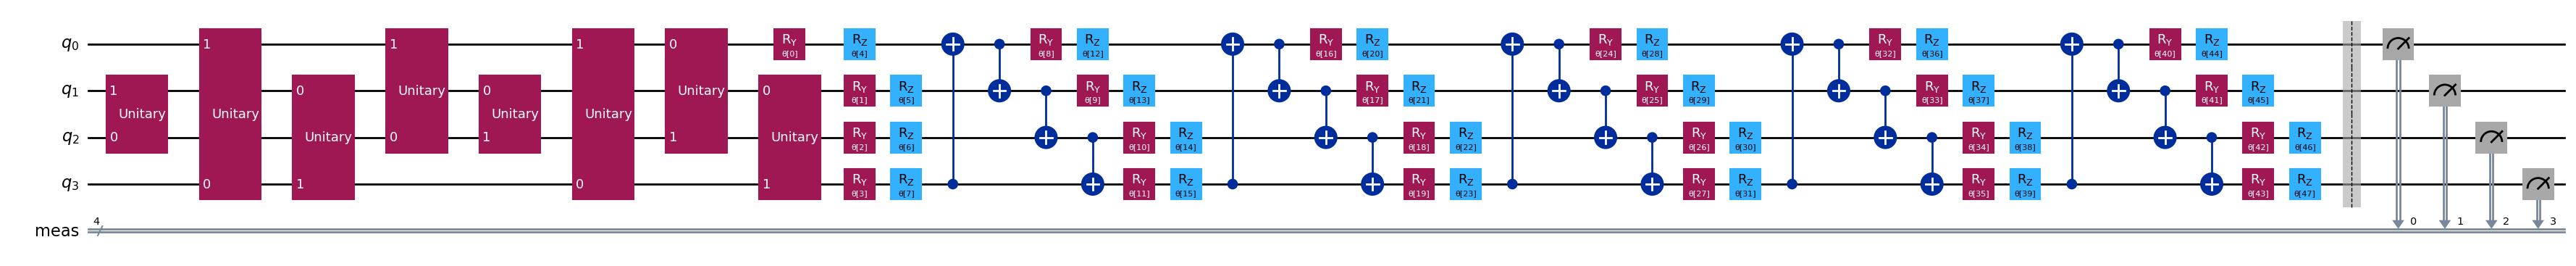

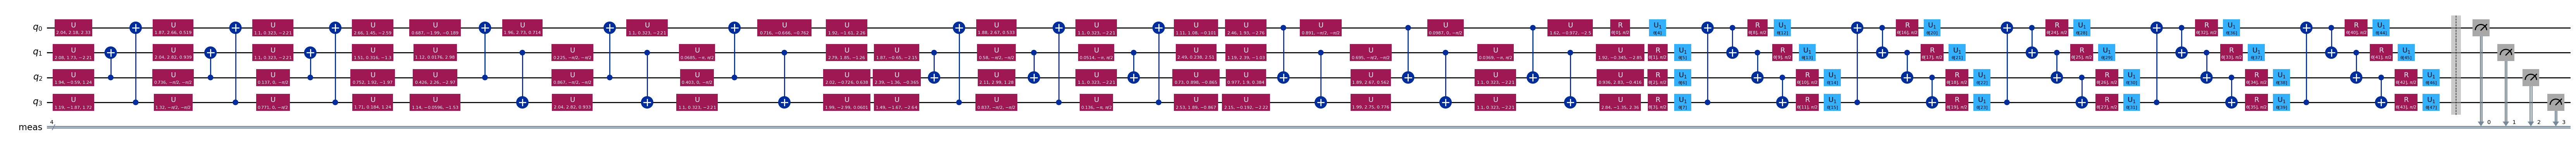

In [ ]:
display(nested_qc.decompose().draw('mpl', fold=-1))
display(nested_qc.decompose(reps=2).draw('mpl', fold=-1))
display(nested_qc.decompose(reps=3).draw('mpl', fold=-1))

### パラメータ

この回路が示すもう一つのことは、パラメータ化された回路です。上記の例では、`EfficientSU2`が48個のθ角度の値からなるベクトルでパラメータ化されています。これらのパラメータは、`assign_parameters`を使ってインプレースで設定するか、新しいコピーとしてバインドできます：


<!-- ### Parameters

The other thing that is demonstrated by this circuit is parameterized circuits. In the above example `EfficientSU2` is parameterized on a vector of 48 θ angle values. These can be bound inplace or as a new copy using `assign_parameters`: -->

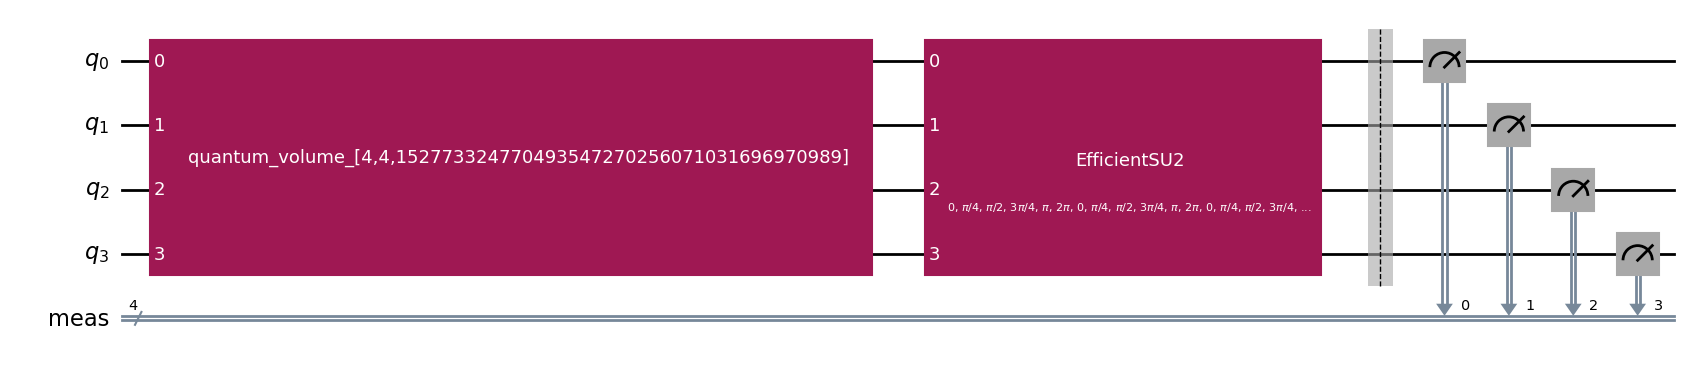

In [ ]:
from math import pi
import itertools

value_cycle = itertools.cycle([0, pi / 4, pi / 2, 3*pi / 4, pi, 2* pi])

nested_qc.assign_parameters([x[1] for x in zip(range(len(nested_qc.parameters)), value_cycle)], inplace=True)
nested_qc.draw('mpl')

これらの`Parameter`オブジェクトは、記号的な式を構築するためにも使用できます：


<!-- These `Parameter` objects can also be used to build symbolic expressions: -->

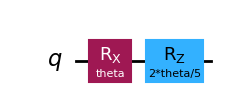

In [ ]:
from qiskit.circuit import Parameter

parameter = Parameter('theta')
qc = QuantumCircuit(1)
qc.rx(parameter, 0)
qc.rz((2*parameter/5), 0)
qc.draw('mpl')

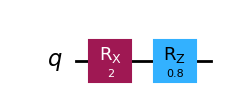

In [ ]:
qc.assign_parameters([2], inplace=True)
qc.draw('mpl')

一部のバックエンドは直接パラメータバインディングをサポートしています。現在の最良の例は`qiskit-aer`で、これにより実行時に各パラメータに使用する値のリストを指定するために`parameter_binds`引数をバックエンドに渡すことができます。これは、Qiskitで各バインド値に対してフル回路をコピーしなければならないため、事前にバインドするよりも効率的です。


<!-- Some backends support direct parameter binding, the best current example is `qiskit-aer` which lets you specify a `parameter_binds` argument to the backend to provide a list of values to use for each parameter at execution time. This ends up being more efficient than binding up front because you have to copy the full circuit for each bound value in Qiskit. -->

### 高レベルオブジェクト

Qiskitの回路モデルは、挿入できるものに関して非常に柔軟です。高レベルのオブジェクトに加えて、数学的な構造を直接挿入することもできます。これらの回路操作は、数学的な用語のみで表され、コンパイル時に（ターゲットバックエンドに対して理想的な方法で）合成されます。例えば：


<!-- ### Higher Level Objects

Qiskit's circuit model is very flexible about what it allows you to insert. Besides higher level of objects you can also directly insert mathematical constructs. These circuit operations are represented only in their mathematical terms on and will be synthesized (potentially in an ideal manner for a target backend) during compilation. For example: -->

In [ ]:
from qiskit.circuit.library import PermutationGate
from qiskit.quantum_info import random_unitary, random_clifford

Unitary Matrix: Operator([[-0.0103952 +0.13379061j, -0.24208086+0.65901089j,
            0.36467987+0.30267736j, -0.28394208+0.42879532j],
          [-0.14489181-0.38146857j, -0.61065834-0.12044158j,
            0.16513598-0.31181012j,  0.45582113+0.33735733j],
          [ 0.30322096+0.15297502j, -0.02229458-0.01635376j,
           -0.36546364+0.61034164j,  0.57013326+0.22969257j],
          [-0.49112701+0.67744377j, -0.03388793-0.34318921j,
            0.36773844+0.09791532j,  0.18802228+0.02766987j]],
         input_dims=(2, 2), output_dims=(2, 2))
Clifford: Stabilizer = ['+XZ', '+XI'], Destabilizer = ['-XX', '+ZY']


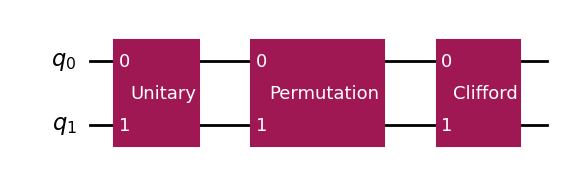

In [ ]:
high_level_qc = QuantumCircuit(2)
unitary = random_unitary(4)
print(f"Unitary Matrix: {unitary}")
clifford = random_clifford(2)
print(clifford)
high_level_qc.unitary(unitary, range(2))
high_level_qc.append(PermutationGate([1, 0]), range(2))
high_level_qc.append(clifford, range(2))

high_level_qc.draw('mpl')

In [ ]:
print("Permutation")
print(high_level_qc.data[1].operation.definition)
print(high_level_qc.data[1].operation.params)
print("Clifford Operator")
print(getattr(high_level_qc.data[2].operation, "definition", None))
print(getattr(high_level_qc.data[2].operation, "tableau"))

Permutation
None
[array([1, 0])]
Clifford Operator
None
[[ True  True False False  True]
 [ True False  True  True False]
 [False  True  True False False]
 [False  True False False False]]


`Operation` [インターフェース](https://qiskit.org/documentation/stubs/qiskit.circuit.Operation.html)を実装した任意のオブジェクトは回路に追加することができます。合成をサポートするために、カスタムオブジェクトの合成を有効にするコンパイラープラグインインターフェースがあります。


<!-- Any object that implements the `Operation` [interface](https://qiskit.org/documentation/stubs/qiskit.circuit.Operation.html) can be added to a circuit. To support synthesis there is a compiler plugin interface to enable custom object synthesis. -->

# バックエンド表現

`QuantumCircuit`オブジェクトの構築と操作のためのAPIに加えて、Qiskitは量子バックエンドを表現するための抽象インターフェースを提供します。このインターフェースは`qiskit.providers`にあり、回路を実行するために使用される`Backend`オブジェクトを提供する「プロバイダー」に基づいて構築されています。`Backend`インターフェースはバージョン管理されており、現在のバージョンは`BackendV2`であり、従来のv1インターフェースもサポートされていますが、現在は広く使用されていません。`BackendV2`は、コンパイラ用にバックエンドの制約をモデル化する`Target`オブジェクトを提供し、回路を実行するためのインターフェースも提供します。`Target`クラスは主に量子の制約に関係し、現在のところ古典計算の制約はモデル化されていません（サポートされている操作に関するものを除いて）。`Target`はバックエンドの抽象的な必須およびオプションのコンポーネントを定義します。しかし、特定のプロバイダーの実装がカスタムフィールドやインターフェースを使ってベースクラスを専門化することが期待されています。これらはQiskitに組み込まれているコードでは使用されていません。


<!-- # Backend Representation

Along with the API for building and interacting with `QuantumCircuit` objects Qiskit provides an abstract interface for representing a quantum backend. This interface located in `qiskit.providers` is built around the "providers"  which provide `Backend` objects that are used to execute circuits. The `Backend` interface is versioned the current version is `BackendV2` and the legacy v1 interface is still supported but not widely used anymore. `BackendV2` provides both a `Target` object to model the constraints of a backend for the compiler and also an interface for running circuits. The `Target` class is primarily with the quantum constraints, and classical computing constraints aren't modeled in it currently (aside from which operations are supported). The `Target` defines the abstract required and optional components of a backend. But it's expected that specific providers' implementation will specialize the base class with custom fields and interfaces. These are just not used by any code built-in to Qiskit. -->

In [ ]:
from qiskit_ibm_runtime.fake_provider import FakeTorino

backend = FakeTorino()

In [ ]:
print(backend.target)

Target
Number of qubits: 133
Instructions:
	cz
		(0, 1):
			Duration: 8.4e-08 sec.
			Error Rate: 0.005550809401863865
			With pulse schedule calibration
		(0, 15):
			Duration: 1.24e-07 sec.
			Error Rate: 0.002277684234803512
			With pulse schedule calibration
		(1, 0):
			Duration: 8.4e-08 sec.
			Error Rate: 0.005550809401863865
			With pulse schedule calibration
		(1, 2):
			Duration: 1.24e-07 sec.
			Error Rate: 0.0032006634205578033
			With pulse schedule calibration
		(2, 1):
			Duration: 1.24e-07 sec.
			Error Rate: 0.0032006634205578033
			With pulse schedule calibration
		(2, 3):
			Duration: 8.4e-08 sec.
			Error Rate: 0.005791093406849163
			With pulse schedule calibration
		(3, 2):
			Duration: 8.4e-08 sec.
			Error Rate: 0.005791093406849163
			With pulse schedule calibration
		(3, 4):
			Duration: 8.4e-08 sec.
			Error Rate: 0.022252123404383817
			With pulse schedule calibration
		(4, 3):
			Duration: 8.4e-08 sec.
			Error Rate: 0.022252123404383817
			With pulse sched

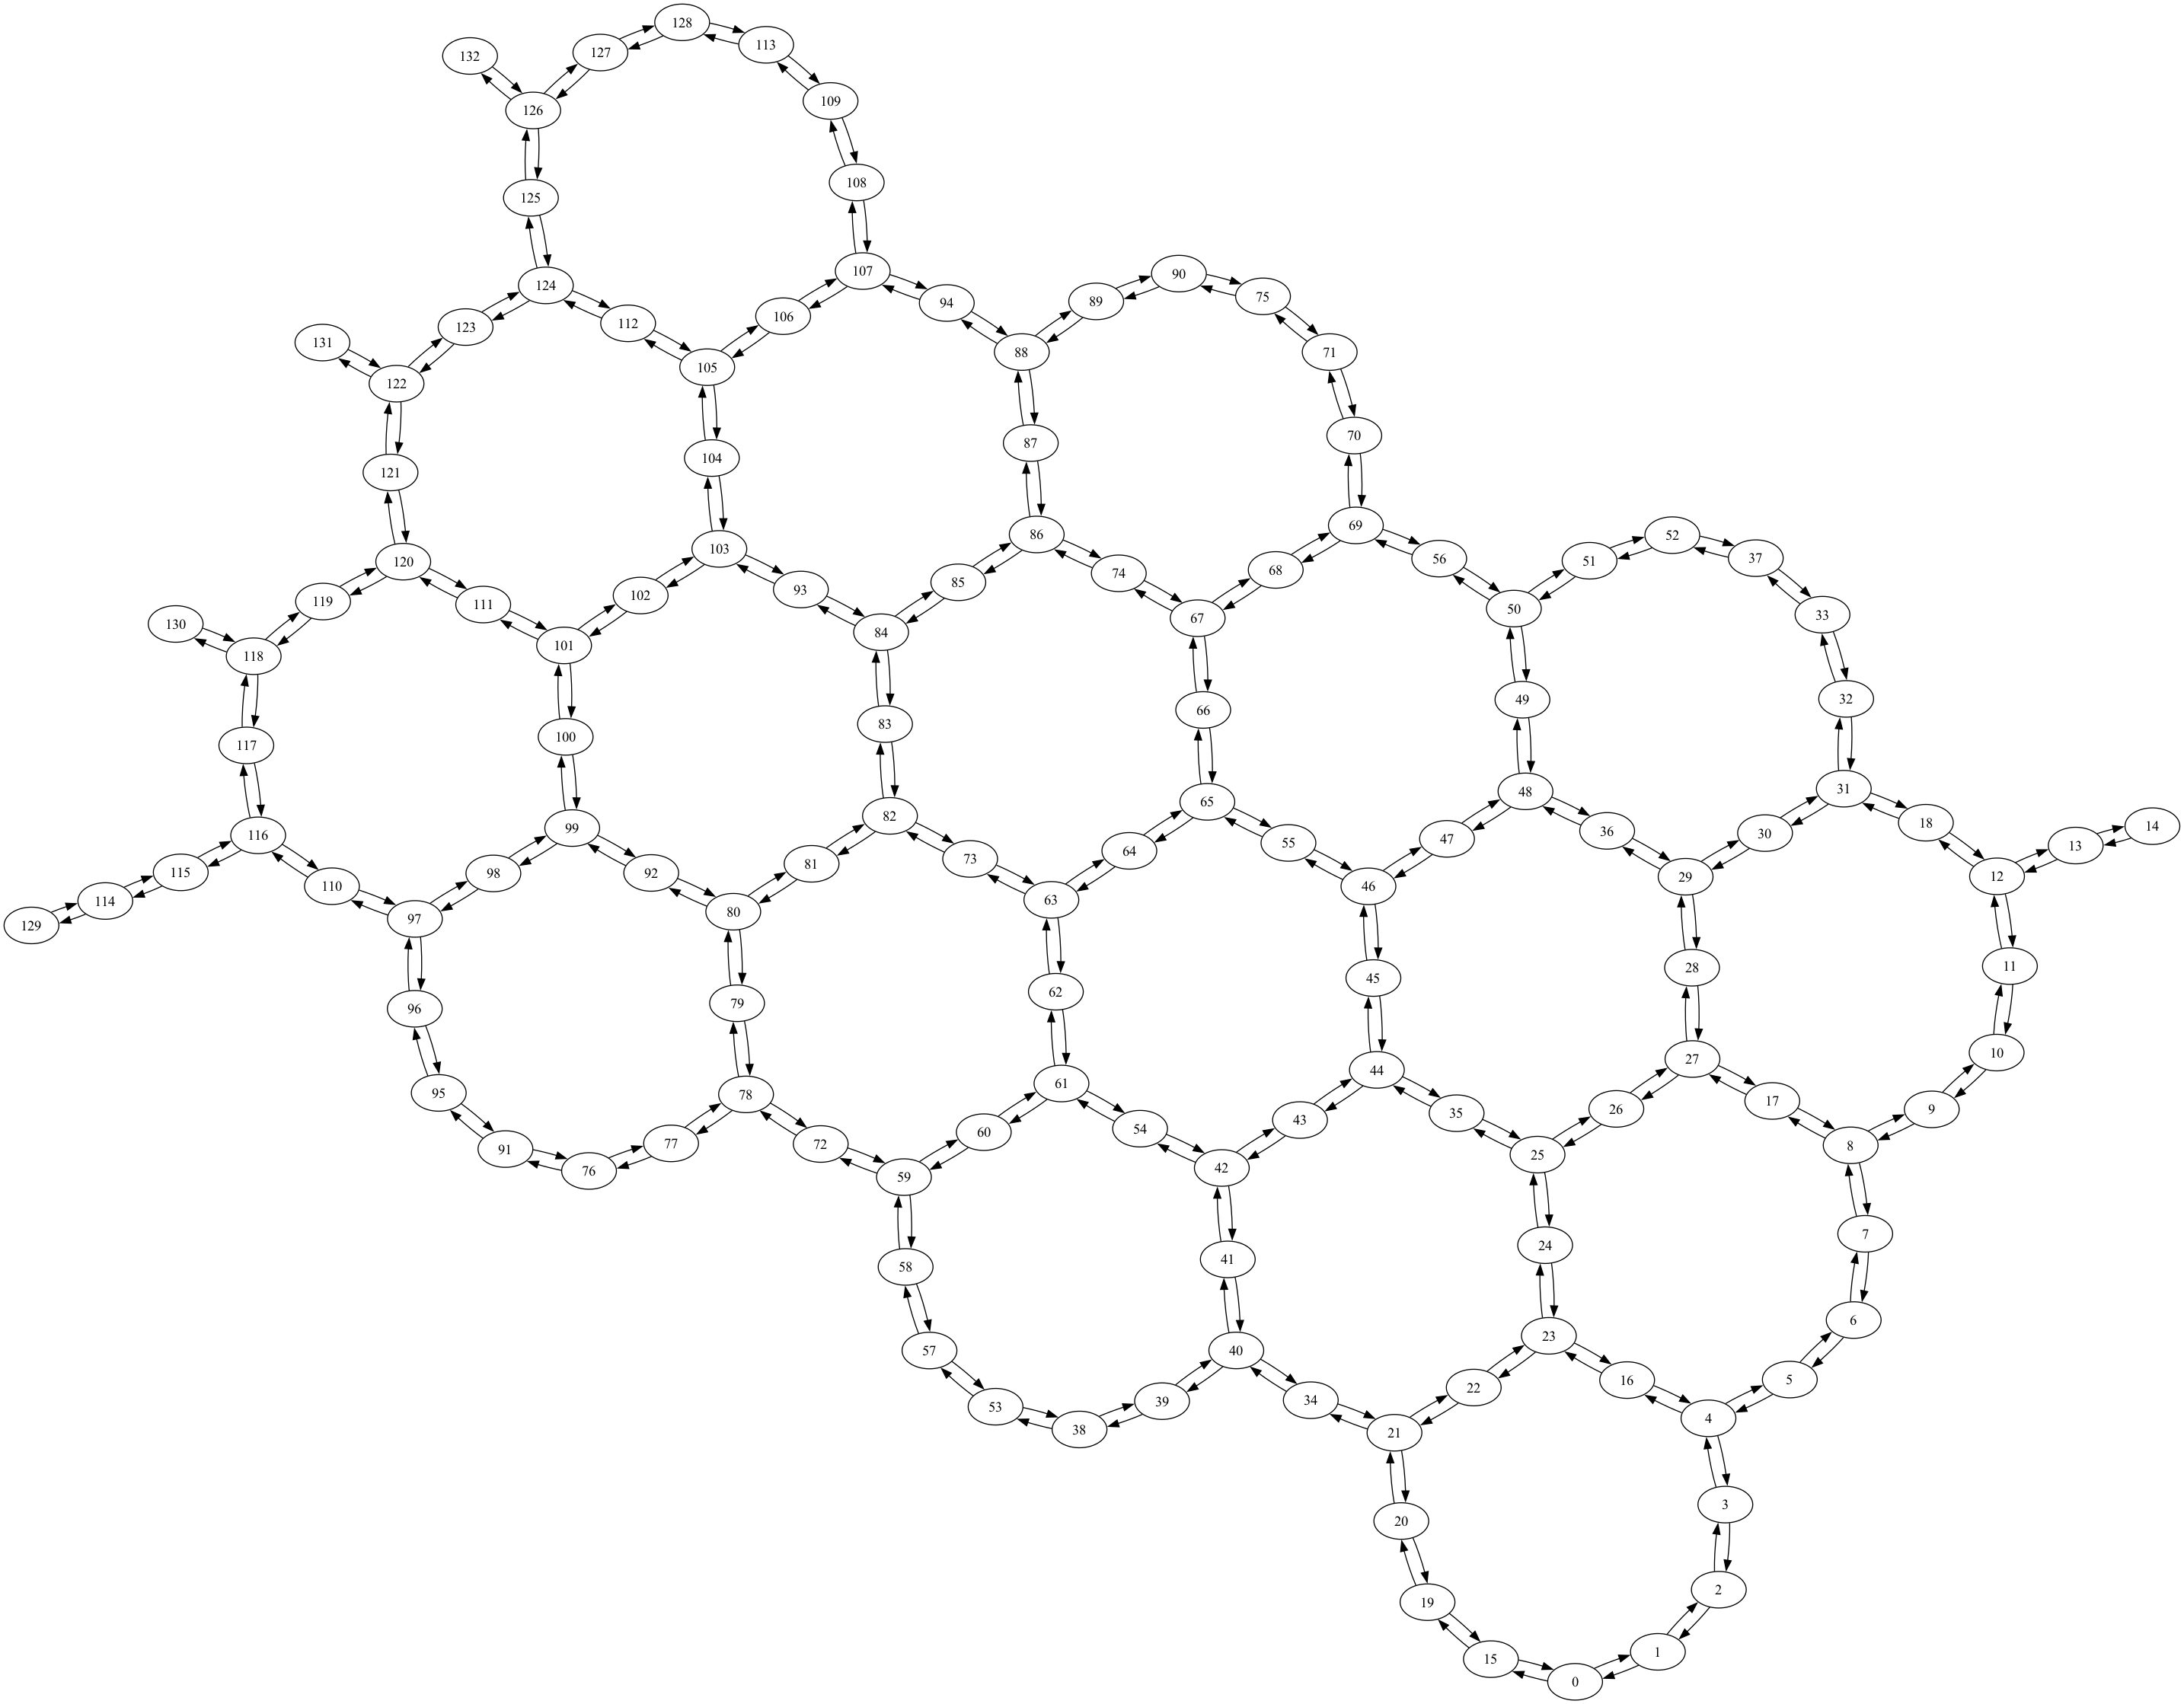

In [ ]:
backend.coupling_map.draw()


上記の例で使用されている`Fake*`バックエンドクラスは、APIからの保存されたJSONレスポンスペイロードを使用しています（ネットワーク遅延を避けるために行われています）。これらとIBMバックエンドのターゲットは、APIを介して返される設定、プロパティ、およびデフォルトのペイロードを使用して構築されています。しかし、これは`qiskit-ibm-runtime`と`qiskit-ibm-provider`がオブジェクトを構築する方法の実装詳細に過ぎません。オブジェクトモデルはQiskitに固有であり、独立しています。これにより、現在のIBMからのAPIレスポンスペイロードで表現できないバックエンドを表現することができます。たとえば、ターゲットは直接構築することができます：


<!-- The above examples using the `Fake*` backend classes are just using stored JSON response payloads from the API (done to avoid network latency). The target for these and IBM backends is built using the configuration, properties, and defaults payload returned via the API. However, this is only an implementation detail of how `qiskit-ibm-runtime` and `qiskit-ibm-provider` build the object and the object model is independent and native to Qiskit.  It's capable of representing backends which are not expressible in the current API response payloads from IBM. For example a target can be constructed directly: -->

In [ ]:
import numpy as np
import rustworkx as rx

from qiskit.providers import BackendV2, Options
from qiskit.transpiler import Target, InstructionProperties
from qiskit.circuit.library import XGate, SXGate, RZGate, CZGate
from qiskit.circuit import Measure, Delay, Parameter, IfElseOp

class ElephantBird(BackendV2):
    """Fake multi chip backend."""

    def __init__(self, distance=3, number_of_chips=3):
        """Instantiate a new multi chip backend.

        Args:
            distance (int): The heavy hex code distance to use for each chips'
                coupling map. This number **must** be odd. The distance relates
                to the number of qubits by:
                :math:`n = \\frac{5d^2 - 2d - 1}{2}` where :math:`n` is the
                number of qubits and :math:`d` is the ``distance``
            number_of_chips (int): The number of chips to have in the multichip backend
                each chip will be a heavy hex graph of ``distance`` code distance.
        """
        super().__init__(name='Elephant Bird')
        graph = rx.generators.directed_heavy_hex_graph(distance, bidirectional=False)
        num_qubits = len(graph) * number_of_chips
        rng = np.random.default_rng(seed=12345678942)
        rz_props = {}
        x_props = {}
        sx_props = {}
        measure_props = {}
        delay_props = {}
        self._target = Target("Elephant Bird", num_qubits=num_qubits)
        for i in range(num_qubits):
            qarg = (i,)
            rz_props[qarg] = InstructionProperties(error=0.0, duration=0.0)
            x_props[qarg] = InstructionProperties(
                error=rng.uniform(1e-7, 1e-2), duration=rng.uniform(1e-8, 9e-7)
            )
            sx_props[qarg] = InstructionProperties(
                error=rng.uniform(1e-7, 1e-2), duration=rng.uniform(1e-8, 9e-7)
            )
            measure_props[qarg] = InstructionProperties(
                error=rng.uniform(1e-3, 1e-1), duration=rng.uniform(1e-8, 9e-7)
            )
            delay_props[qarg] = None
        self._target.add_instruction(XGate(), x_props)
        self._target.add_instruction(SXGate(), sx_props)
        self._target.add_instruction(RZGate(Parameter("theta")), rz_props)
        self._target.add_instruction(Measure(), measure_props)
        self._target.add_instruction(Delay(Parameter("t")), delay_props)
        cz_props = {}
        for i in range(number_of_chips):
            for root_edge in graph.edge_list():
                offset = i * len(graph)
                edge = (root_edge[0] + offset, root_edge[1] + offset)
                cz_props[edge] = InstructionProperties(
                    error=rng.uniform(1e-5, 5e-3), duration=rng.uniform(1e-8, 9e-7)
                )
        self._target.add_instruction(CZGate(), cz_props)
        self._target.add_instruction(IfElseOp, name="if_else")

    @property
    def target(self):
        return self._target

    @property
    def max_circuits(self):
        return None

    @classmethod
    def _default_options(cls):
        return Options(shots=1024)

    def run(self, circuit, **kwargs):
        raise NotImplementedError("Lasciate ogne speranza, voi ch'intrate")

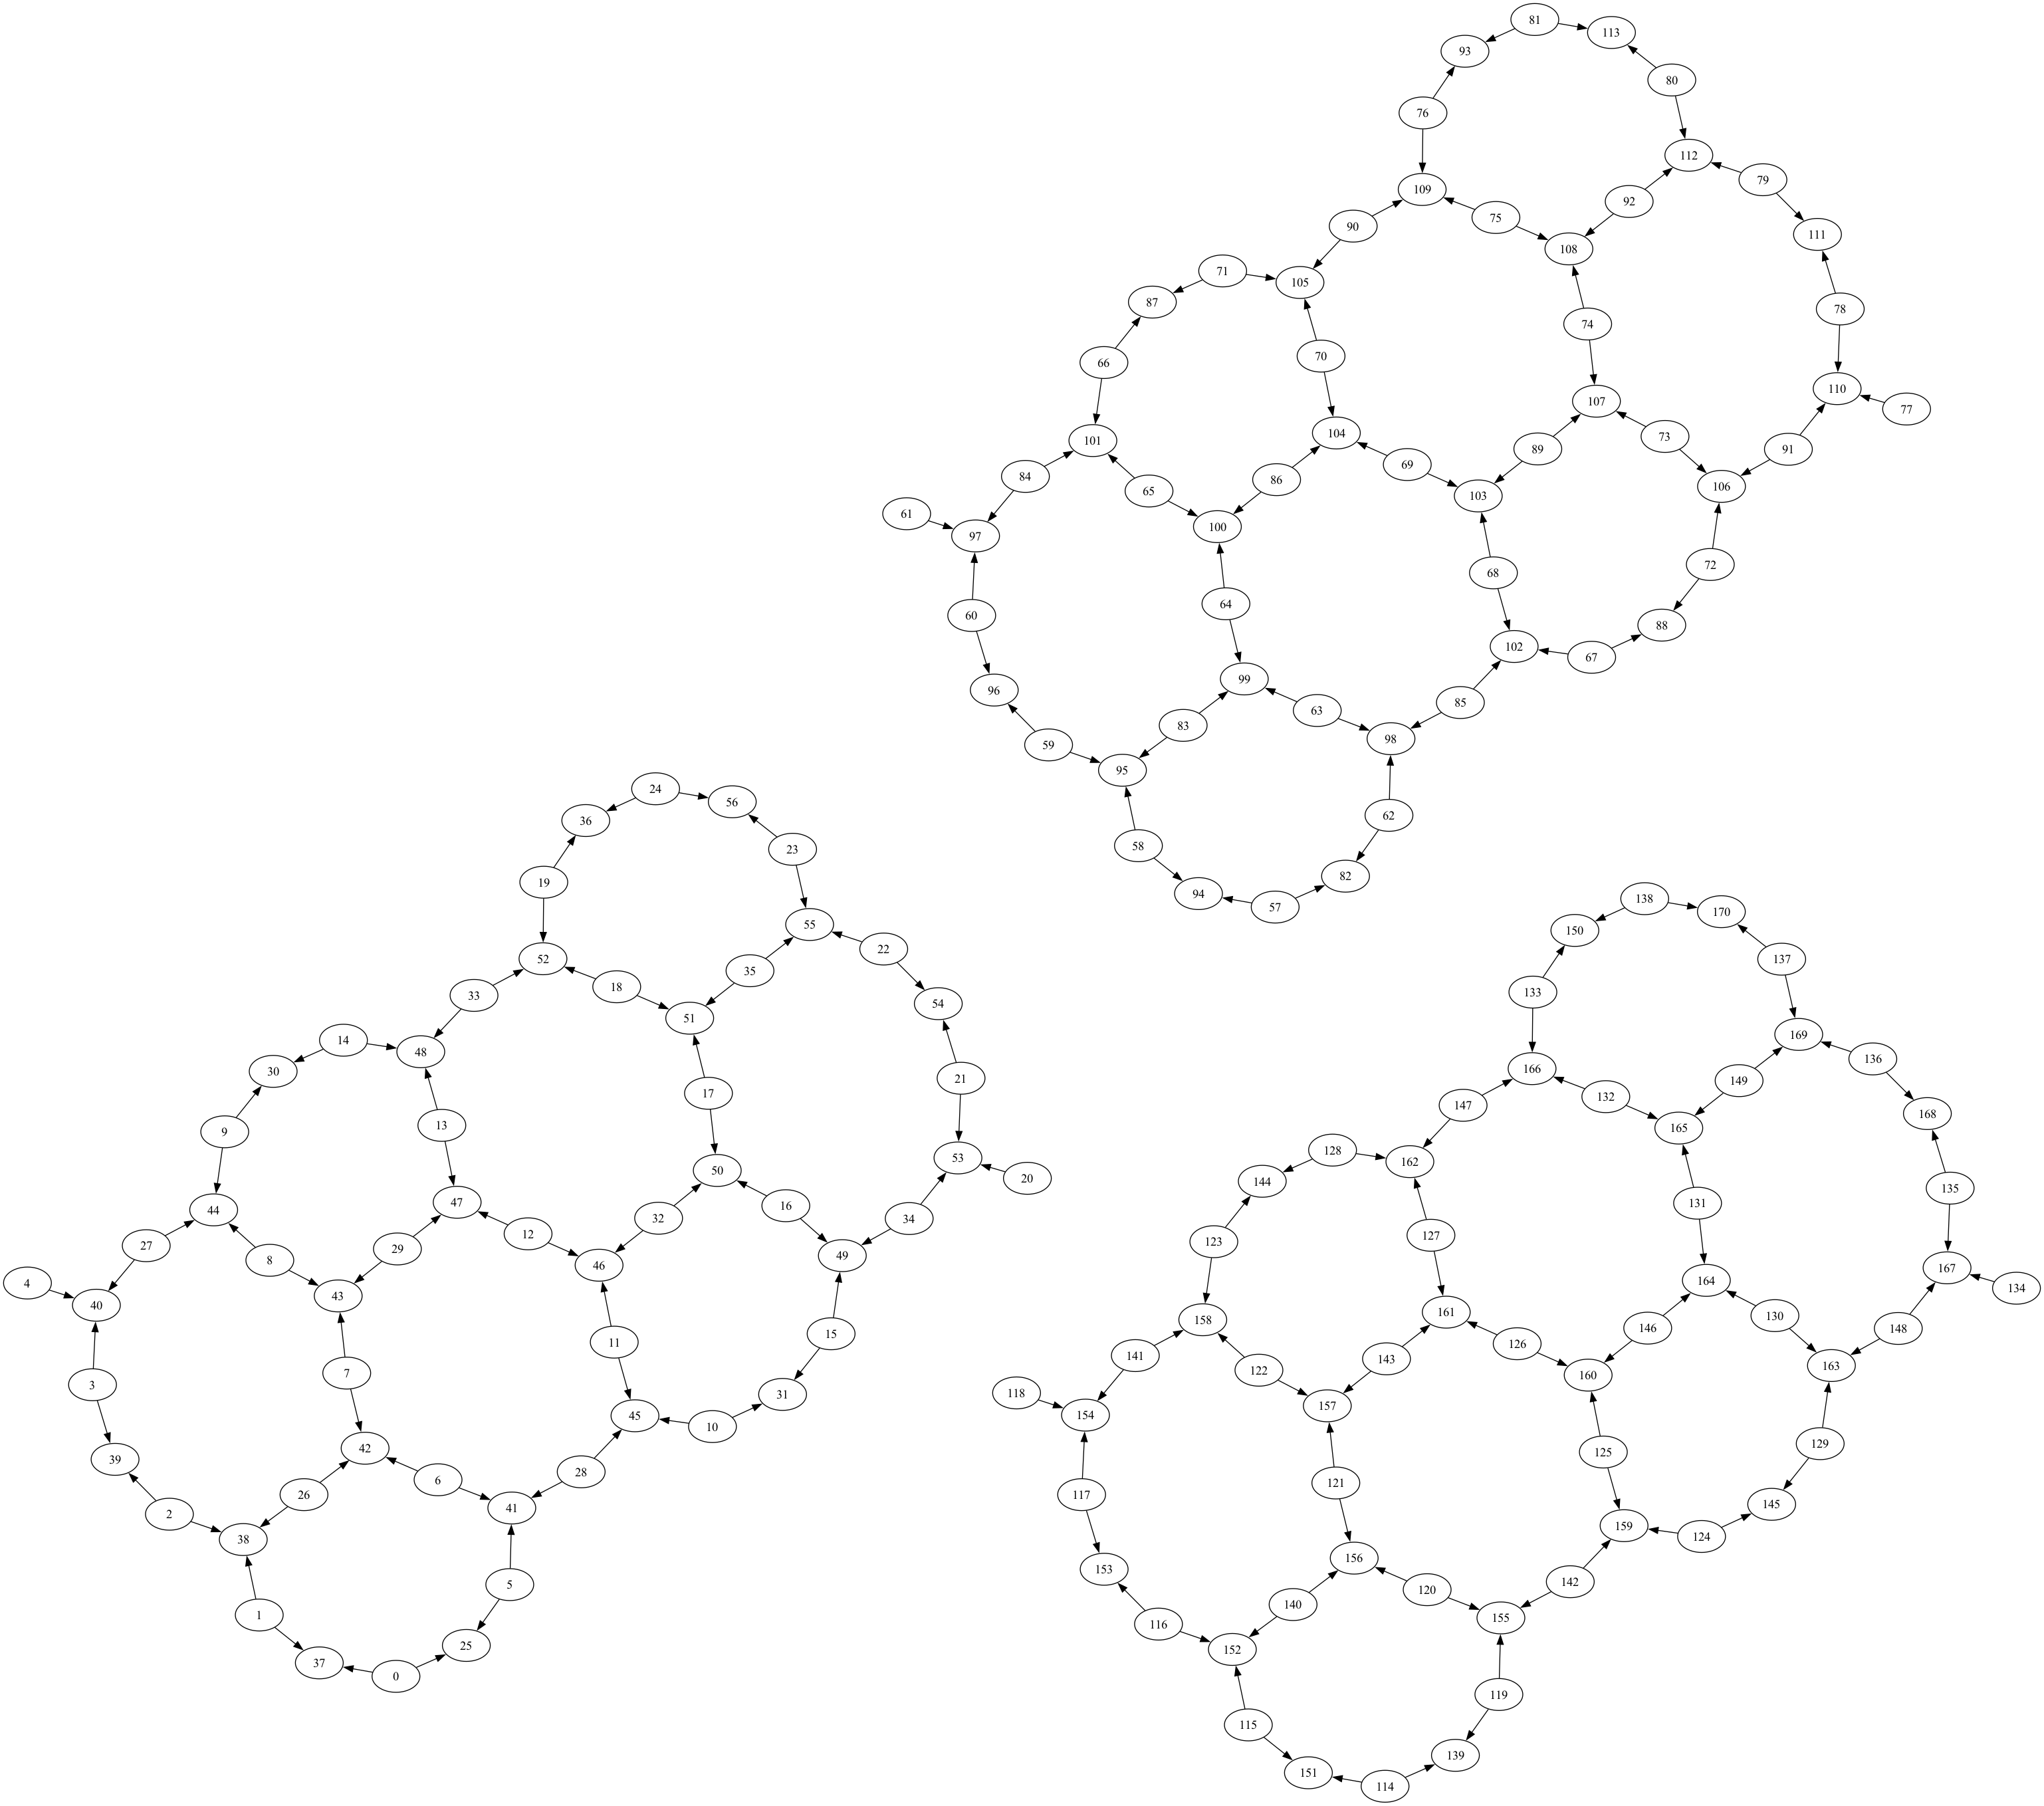

In [ ]:
backend = ElephantBird(5, 3)
backend.coupling_map.draw()

In [ ]:
print(backend.num_qubits)

171


バックエンドのトポロジー、例えばバックエンドオブジェクトの接続性や結合マップの方向性は重要です。回路によっては、このトポロジーがトランスパイル後の最終的な深さに大きく影響することがあります。では、ランダム回路を考えてみましょう。


<!-- It is important to note the topology of a backend, shown for example by the connectivity and the directionality of the coupling map of a backend object. Depending on the circuits, the topology may greatly affect the resulting depth after transpilation. Let's consider a random circuit -->

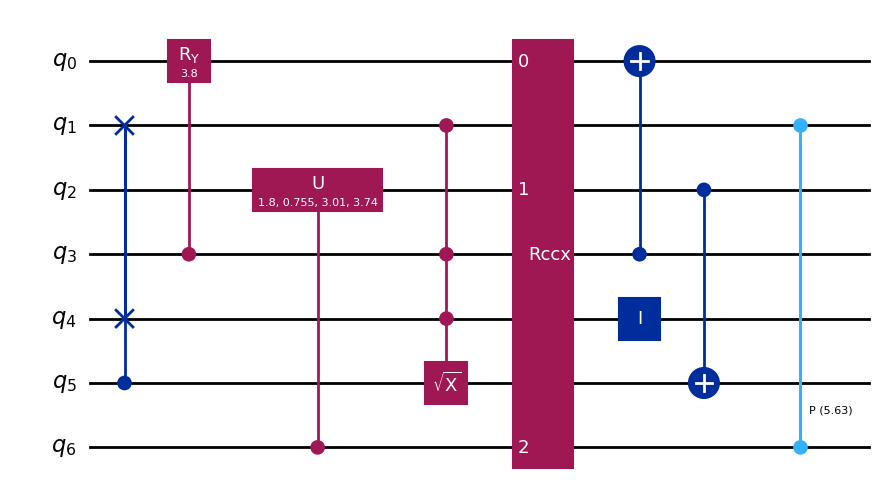

In [ ]:
from qiskit.circuit.random import random_circuit

num_qubits = 7
depth=3

# Create a qrandom quantum circuit
qc = random_circuit(num_qubits=num_qubits, depth=depth)

qc.draw('mpl')

次に、異なる接続性を持つ2つのバックエンドのトポロジーを考えます：線形接続と全結合接続です。線形接続は、量子ビットがチェーン上に配置された隣接する量子ビットとしか相互作用できないことを意味します。一方、全結合接続のトポロジーでは、すべての量子ビットが他のすべての量子ビットと接続されています。


<!-- Now consider two backend topologies with different connectivity: linear and all-to-all. A linear connectivity means qubits can only interact with neighboring qubits placed on a chain. In a topology with all-to-all connectivity every qubit is connected to every other qubit. -->

Linear coupling map
2q-depth: 14
2q-size: 21


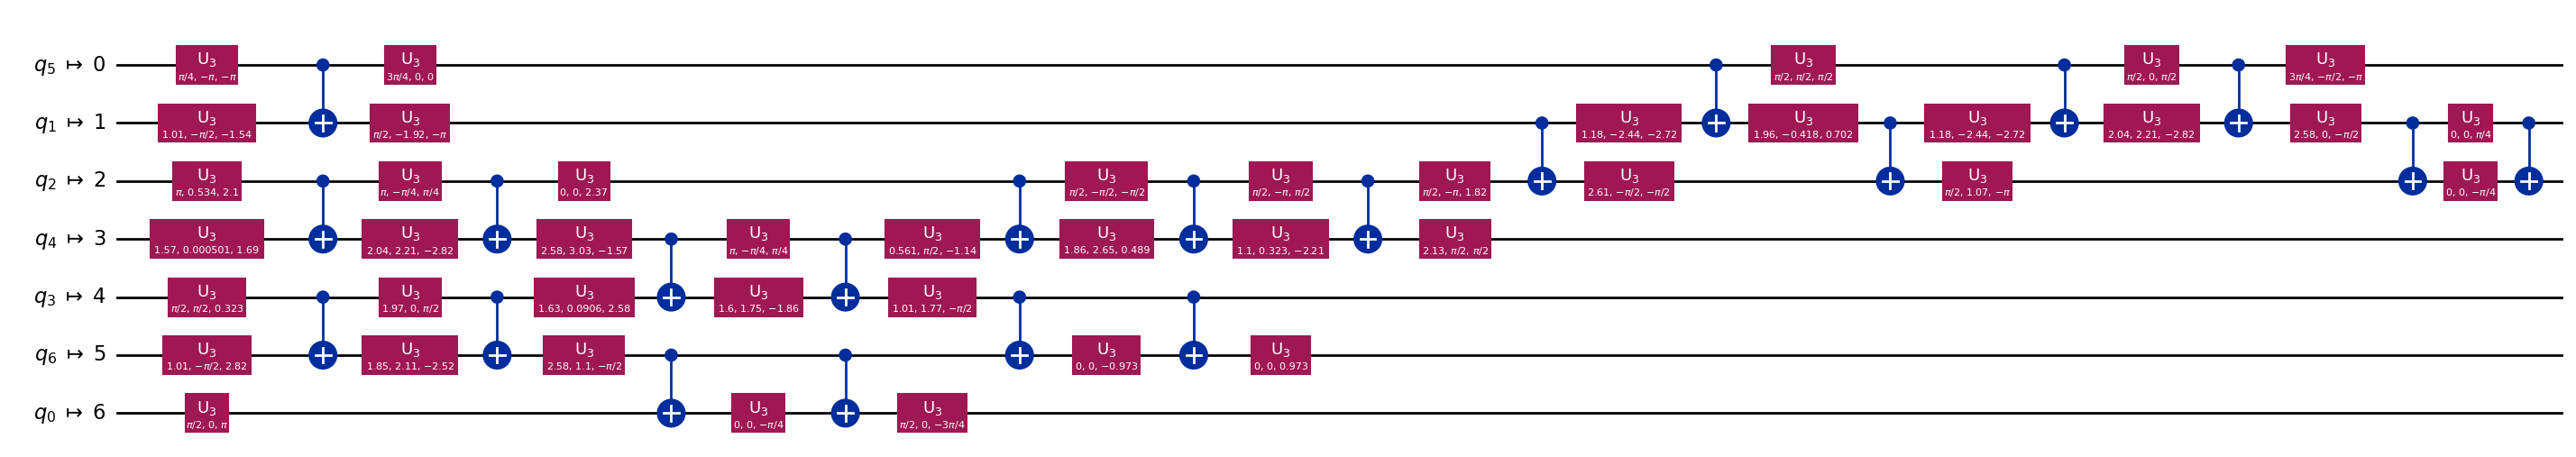

All to all coupling map
2q-depth: 10
2q-size: 17


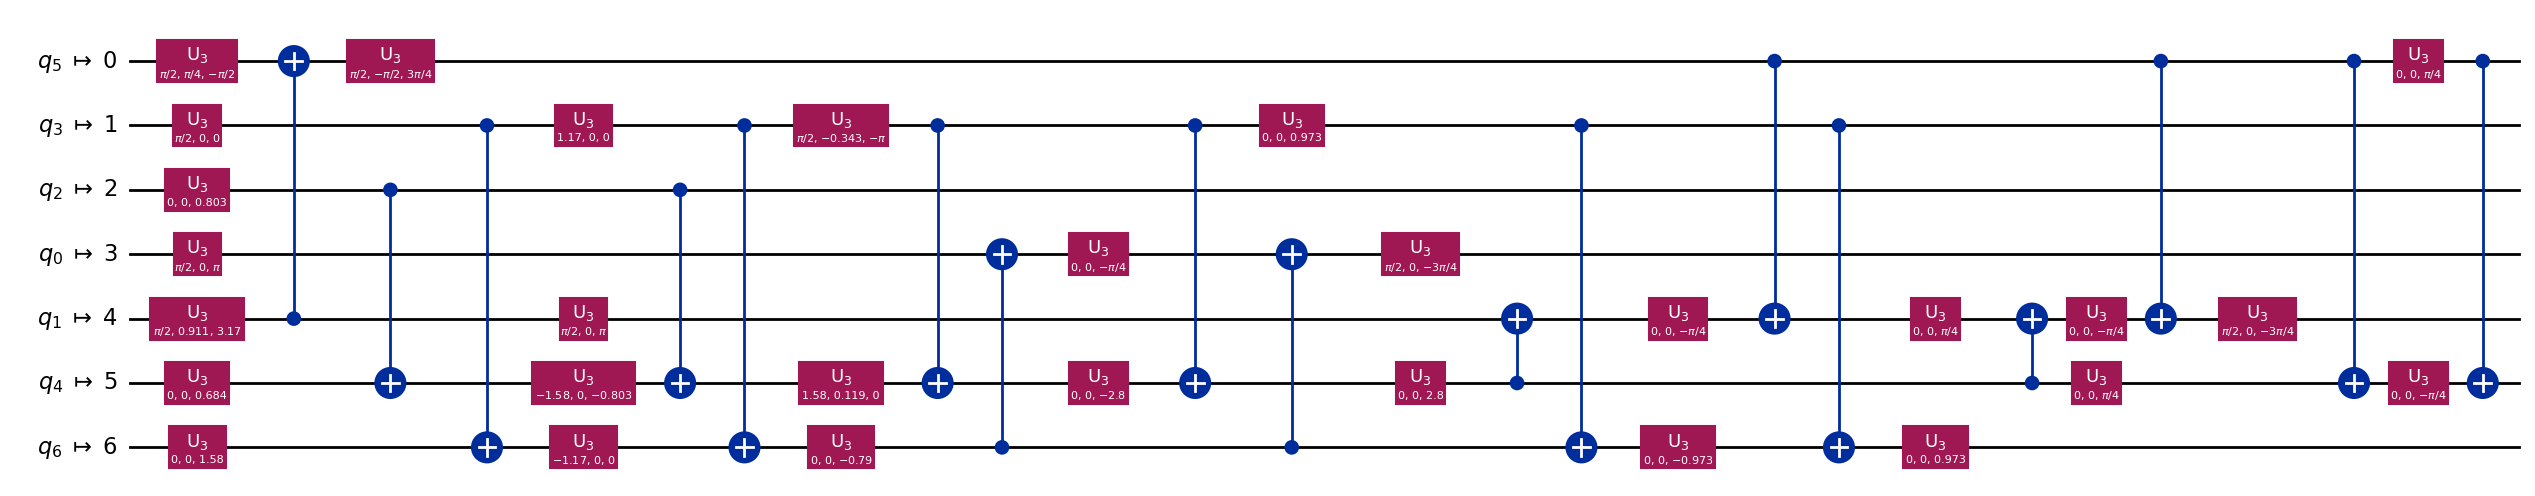

In [ ]:
from qiskit.compiler import transpile
from qiskit.transpiler import CouplingMap

linear_coupling_map = CouplingMap([[i,i+1] for i in range(num_qubits-1)])
all_to_all_coupling_map = CouplingMap([[i, j] for i in range(num_qubits) for j in range(num_qubits) if i != j])


print("Linear coupling map")
qc_linear = transpile(qc, optimization_level=3, coupling_map=linear_coupling_map, basis_gates=['u3', 'cx'])
print(f'2q-depth: {qc_linear.depth(lambda x: x.operation.num_qubits==2)}')
print(f'2q-size: {qc_linear.size(lambda x: x.operation.num_qubits==2)}')
display(qc_linear.draw('mpl', fold=-1))

print("All to all coupling map")
qc_all = transpile(qc, optimization_level=3, coupling_map=all_to_all_coupling_map, basis_gates=['u3', 'cx'])
print(f'2q-depth: {qc_all.depth(lambda x: x.operation.num_qubits==2)}')
print(f'2q-size: {qc_all.size(lambda x: x.operation.num_qubits==2)}')
display(qc_all.draw('mpl', fold=-1))

# Qiskit コンパイラ/トランスパイラー

Qiskitには、ユーザーが構築した抽象的で高レベルな回路を取り、それを選択したバックエンドで実行可能で最適化された回路に変換するコンパイラが含まれています。変換は、バックエンドの`Target`で提供される制約に基づいて行われます。コンパイルの主なエントリーポイントは`transpile()`関数です：


<!-- # Qiskit Compiler/Transpiler

Qiskit includes a compiler that takes the abstract, high level circuit, built by a user and transforms it into a circuit that is optimized and runnable on the selected backend by the constraints provided in it's `Target`. The primary entrypoint for compilation is the `transpile()` function: -->

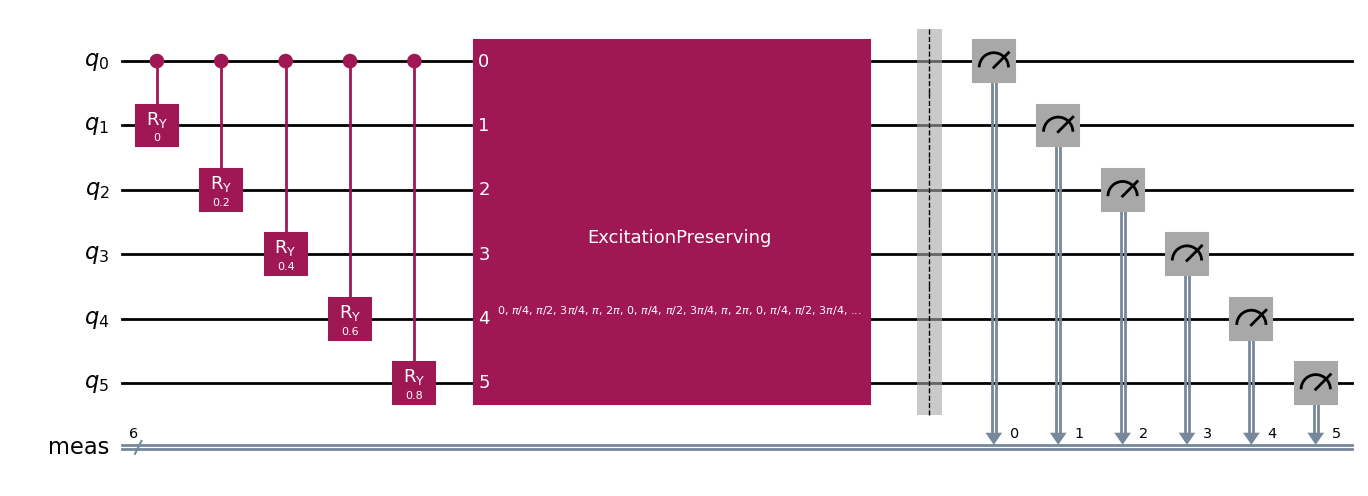

In [ ]:
from qiskit.compiler import transpile
from qiskit.circuit.library import ExcitationPreserving
from qiskit_ibm_runtime.fake_provider import FakeLagosV2

# Use Fake Lagos (a 7q device) for simpler visualization
backend = FakeLagosV2()

num_qubits = 6
qc = QuantumCircuit(num_qubits)
for i in range(num_qubits - 1):
    qc.cry(0.2 * i, 0, i + 1)
qc.append(ExcitationPreserving(num_qubits, reps=1, flatten=True), range(num_qubits))
qc.measure_all()

value_cycle = itertools.cycle([0, pi / 4, pi / 2, 3*pi / 4, pi, 2* pi])
qc.assign_parameters([x[1] for x in zip(range(len(qc.parameters)), value_cycle)], inplace=True)
qc.draw('mpl', fold=-1)

2q-depth: 64
2q-size: 81


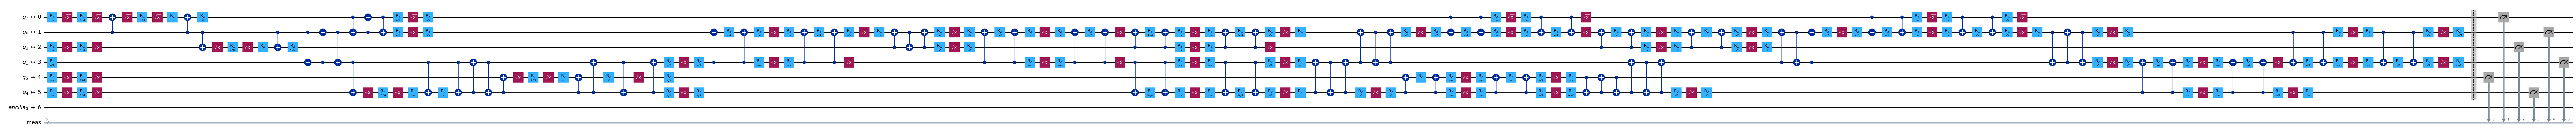

In [ ]:
qc_t = transpile(qc, backend)

print(f'2q-depth: {qc_t.depth(lambda x: x.operation.num_qubits==2)}')
print(f'2q-size: {qc_t.size(lambda x: x.operation.num_qubits==2)}')
qc_t.draw('mpl', fold=-1)

利用可能な`optimization_level`は0から3までの4つです。最適化レベルが高いほど、回路を最適化するために費やされる計算量が増えます。レベル0は最適化を行わず、選択したバックエンドで回路が実行可能になるために必要な最小限の作業だけを行います。レベル3は最も多くの労力（通常は実行時間も）を費やして回路を最適化しようとします。レベル1はデフォルトの最適化レベルです。

`optimization_level`のオプションは次の通りです：

| 最適化レベル | Estimator & Sampler |
| :--- | :--- |
| 0 | 最適化なし：主にハードウェアの特性評価やデバッグに使用されます <br /> - 基礎ゲートの翻訳 <br /> - レイアウト（指定された通り） <br /> - ルーティング（確率的SWAP） |
| 1, 2, 3 | 軽度な最適化：<br /> - レイアウト（trivial → vf2 → SabreLayout、ルーティングが必要な場合） <br /> - ルーティング（必要ならSabreSWAP） <br /> - 1量子ビットゲートの最適化 |


<!-- There are 4 available `optimization_level`s from 0-3. The higher the optimization level the more computational effort is spent to optimize the circuit. Level 0 performs no optimization and just does the minimal amount of work to make the circuit runnable on the selected backend. Level 3 spends the most amount if effort (and typically runtime) to try an optimize the circuit. Level 1 is the default optimization level.



The options for `optimization_level` are:

| Optimization Level | Estimator & Sampler |
| :--- | :--- |
| 0 | No optimization: typically used for hardware characterization or debugging <br />    - Basis translation <br /> - Layout (as specified) <br /> - Routing (stochastic swaps) |
| 1, 2, 3 | Light optimization:  - Layout (trivial → vf2 → SabreLayout if routing is required) <br /> - Routing (SabreSWAPs if needed) <br /> - 1Q gate optimization <br /> | -->


Optimization Level 2:
2q-depth: 35
2q-size: 42


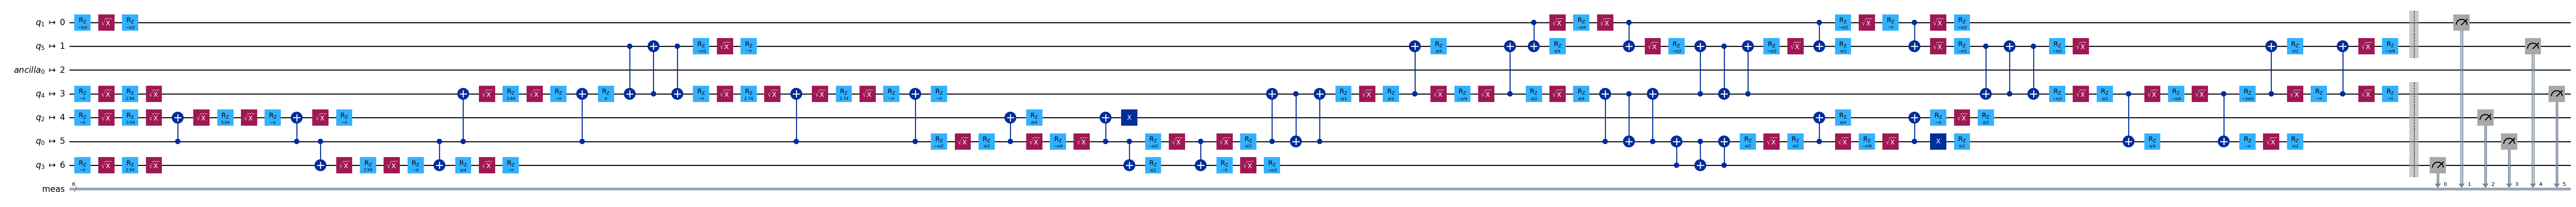

Optimization Level 3:
2q-depth: 35
2q-size: 40


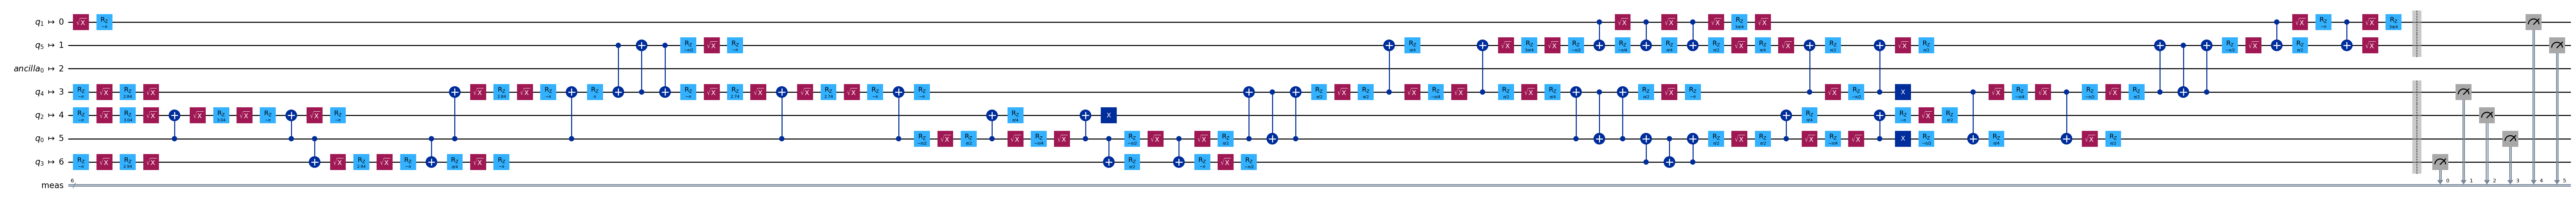

In [ ]:
print("Optimization Level 2:")
qc_t = transpile(qc, backend, optimization_level=2, output_name="Level2")
print(f'2q-depth: {qc_t.depth(lambda x: x.operation.num_qubits==2)}')
print(f'2q-size: {qc_t.size(lambda x: x.operation.num_qubits==2)}')
display(qc_t.draw('mpl', fold=-1))

print("Optimization Level 3:")
qc_t = transpile(qc, backend, optimization_level=3, output_name="Level3")
print(f'2q-depth: {qc_t.depth(lambda x: x.operation.num_qubits==2)}')
print(f'2q-size: {qc_t.size(lambda x: x.operation.num_qubits==2)}')
display(qc_t.draw('mpl', fold=-1))